In [1]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm_notebook
import pickle
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1 Aquisição dos dados

In [3]:
categorias = sorted(os.listdir('animals/'))

In [4]:
categorias

['cats', 'dogs', 'panda']

In [5]:
dataset = sorted(glob('animals' + "/*/*", recursive = True))
dataset[:10]

['animals/cats/cats_00001.jpg',
 'animals/cats/cats_00002.jpg',
 'animals/cats/cats_00003.jpg',
 'animals/cats/cats_00004.jpg',
 'animals/cats/cats_00005.jpg',
 'animals/cats/cats_00006.jpg',
 'animals/cats/cats_00007.jpg',
 'animals/cats/cats_00008.jpg',
 'animals/cats/cats_00009.jpg',
 'animals/cats/cats_00010.jpg']

In [6]:
len(dataset)

3000

# 2 Pré-processamento

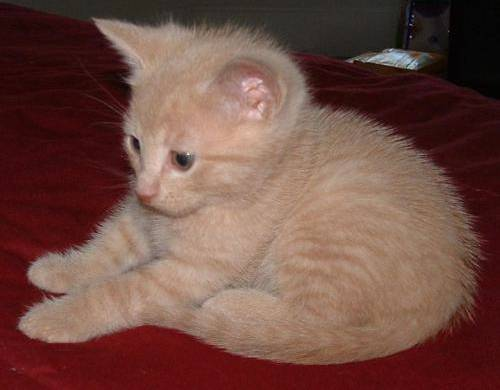

In [7]:
test = load_img(dataset[3])
test

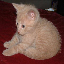

In [8]:
test = load_img(dataset[3],target_size=(64,64))
test

In [9]:
testNp = np.array(test,dtype='float')
testNp

array([[[32., 16., 17.],
        [41., 31., 30.],
        [53., 43., 42.],
        ...,
        [ 6.,  6.,  6.],
        [ 5.,  5.,  5.],
        [ 4.,  4.,  2.]],

       [[36.,  3., 10.],
        [36.,  7., 12.],
        [42.,  9., 16.],
        ...,
        [ 6.,  6.,  6.],
        [ 4.,  4.,  4.],
        [ 4.,  4.,  2.]],

       [[43., 12., 17.],
        [39., 10., 14.],
        [42., 10., 15.],
        ...,
        [ 6.,  6.,  6.],
        [ 6.,  6.,  6.],
        [ 3.,  3.,  1.]],

       ...,

       [[97., 15., 21.],
        [86., 14., 17.],
        [88., 12., 16.],
        ...,
        [80., 14., 16.],
        [78., 12., 14.],
        [76., 12., 13.]],

       [[98., 18., 19.],
        [96., 14., 16.],
        [95., 16., 21.],
        ...,
        [84., 13., 17.],
        [85., 14., 18.],
        [83., 15., 16.]],

       [[93., 13., 12.],
        [97., 16., 22.],
        [94., 14., 17.],
        ...,
        [86., 16., 18.],
        [80., 10., 12.],
        [79.,  7., 11.]]

In [10]:
testNp.shape

(64, 64, 3)

In [11]:
datasetNp = []
labels = []

for image in tqdm_notebook(dataset):
    img = load_img(image, target_size=(64,64))
    imgNp = np.array(img, dtype='float')
    datasetNp.append(imgNp)
    
    if 'cats' in image:
        label = 0
    
    elif 'dogs' in image:
        label = 1
        
    elif 'panda' in image:
        label=2
        
    labels.append(label)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
print(len(datasetNp))
print(len(labels))

3000
3000


# 3 Divisão treino/teste

In [13]:
##divisao 80/20
x_train = datasetNp[:800] + datasetNp[1000:1800] + datasetNp[2000:2800]
y_train = labels[:800] + labels[1000:1800] + labels[2000:2800]
x_test = datasetNp[800:1000] + datasetNp[1800:2000] + datasetNp[2800:]
y_test = labels[800:1000] + labels[1800:2000] + labels[2800:]

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2400 2400
600 600


In [14]:
#alterando o intervalo dos pixels paraa [0,1]
x_train = np.array(x_train, dtype="float") / 255.0
x_test = np.array(x_test, dtype="float") / 255.0

#transformando a label em categorica
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [15]:
#embaralhando os dados
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2400, 64, 64, 3)
(2400, 3)
(600, 64, 64, 3)
(600, 3)


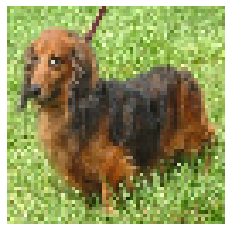

In [17]:
plt.imshow(x_train[30],
           interpolation="nearest")
plt.axis("off")
plt.show()

In [18]:
y_train[30]

array([0., 1., 0.], dtype=float32)

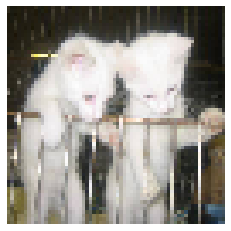

In [19]:
plt.imshow(x_test[45],
           interpolation="nearest")
plt.axis("off")
plt.show()

In [20]:
y_test[45]

array([1., 0., 0.], dtype=float32)

# 4 Arquitetura da CNN

In [21]:
# Inicializando a CNN
classifier = Sequential()

#Camada de convolução
classifier.add(Convolution2D(32, kernel_size=(3,3), input_shape = (64, 64,3), activation = 'relu', padding='same', name = 'conv_1'))

#Camada de pooling
classifier.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='same', name = 'pool_1'))

#Segunda camada convolucional
classifier.add(Convolution2D(64, kernel_size=(3,3), activation = 'relu', padding='same', name = 'conv_2'))

#Dropout
classifier.add(Dropout(0.25))

#Segunda camada de pooling
classifier.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name = 'pool_2'))


#Vetorizando os mapas de características do último pooling (camada de entrada)
classifier.add(Flatten())

#Dropout
classifier.add(Dropout(0.5))

#Camada totalmente conectada ou oculta
classifier.add(Dense(activation='relu', units=128, name = 'dense_1'))


#Camada de saída
classifier.add(Dense(activation='softmax', units=3,  name = 'classification'))

2022-09-15 12:30:55.491308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 12:30:55.491848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-15 12:30:55.496635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-15 12:30:55.496654: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries

In [22]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dropout_1 (Dropout)         (None, 16384)             0

# 5 Treinando o modelo


### Resultados:

-----
**epochs = 100, batch_size = 64**

Test loss: 0.6289

Test accuracy: 0.7233

---
---
**epochs = 200, batch_size = 64**

Test loss: 0.6124

Test accuracy: 0.7400

---
---
**epochs = 200, batch_size = 128**

Test loss: 0.5795

Test accuracy: 0.7583

---
---
**epochs = 200, batch_size = 256**

Test loss: 0.6004

Test accuracy: 0.74

---


## 5.1 Teste 01: alterando o nº de epocas e batch_size

In [23]:
#Parâmetros de treinamento
epochs = 200
batch_size = 128
validation_split=0.1

In [24]:
classifier.compile(optimizer = 'sgd', loss= 'categorical_crossentropy', metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch') 
earlystop = keras.callbacks.EarlyStopping(patience=15)

In [25]:
classifier.fit(x_train, y_train, validation_split=validation_split, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,earlystop], verbose=1)

Epoch 1/200
17/17 [==============================] - ETA: 0s - loss: 1.0894 - accuracy: 0.3773
Epoch 1: val_loss improved from inf to 1.05982, saving model to best_model.h5
17/17 [==============================] - 3s 141ms/step - loss: 1.0894 - accuracy: 0.3773 - val_loss: 1.0598 - val_accuracy: 0.4708
Epoch 2/200
17/17 [==============================] - ETA: 0s - loss: 1.0370 - accuracy: 0.4810
Epoch 2: val_loss improved from 1.05982 to 1.01615, saving model to best_model.h5
17/17 [==============================] - 2s 128ms/step - loss: 1.0370 - accuracy: 0.4810 - val_loss: 1.0161 - val_accuracy: 0.5333
Epoch 3/200
17/17 [==============================] - ETA: 0s - loss: 0.9721 - accuracy: 0.5245
Epoch 3: val_loss improved from 1.01615 to 0.97175, saving model to best_model.h5
17/17 [==============================] - 2s 132ms/step - loss: 0.9721 - accuracy: 0.5245 - val_loss: 0.9718 - val_accuracy: 0.5333
Epoch 4/200
17/17 [==============================] - ETA: 0s - loss: 0.9398 - ac

In [26]:
best_model = keras.models.load_model("best_model.h5")

In [27]:
score = best_model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0],4))
print("Test accuracy:", round(score[1],4))

Test loss: 0.5984
Test accuracy: 0.7417


## 5.2 Teste 02: alterando as camadas

In [28]:
# Inicializando a CNN
classifier2 = Sequential()

#Camada de convolução
classifier2.add(Convolution2D(32, kernel_size=(3,3), input_shape = (64, 64,3), activation = 'relu', padding='same', name = 'conv_1'))

#Camada de pooling
classifier2.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding='same', name = 'pool_1'))

#Segunda camada convolucional
classifier2.add(Convolution2D(64, kernel_size=(3,3), activation = 'relu', padding='same', name = 'conv_2'))

#Dropout
classifier2.add(Dropout(0.25))

#Segunda camada de pooling
classifier2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name = 'pool_2'))

#Terceira camada convolucional
classifier2.add(Convolution2D(128, kernel_size=(3,3), activation = 'relu', padding='same', name = 'conv_3'))

# #Dropout
classifier2.add(Dropout(0.25))

#Terceira camada de pooling
classifier2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same', name = 'pool_3'))

#Vetorizando os mapas de características do último pooling (camada de entrada)
classifier2.add(Flatten())

#Dropout
classifier2.add(Dropout(0.5))

#Camada totalmente conectada ou oculta
classifier2.add(Dense(activation='relu', units=128, name = 'dense_1'))


#Camada de saída
classifier2.add(Dense(activation='softmax', units=3,  name = 'classification'))

In [29]:
classifier2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 pool_2 (MaxPooling2D)       (None, 16, 16, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 16, 16, 128)       73856     
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)      

In [40]:
#Parâmetros de treinamento
epochs = 500
batch_size = 128
validation_split=0.1

In [41]:
classifier2.compile(optimizer = 'sgd', loss= 'categorical_crossentropy', metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint('best_model_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch') 
earlystop = keras.callbacks.EarlyStopping(patience=15)

In [42]:
classifier2.fit(x_train, y_train, validation_split=validation_split, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,earlystop], verbose=1)

Epoch 1/500
17/17 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.8829
Epoch 1: val_loss improved from inf to 0.56492, saving model to best_model_2.h5
17/17 [==============================] - 3s 156ms/step - loss: 0.2950 - accuracy: 0.8829 - val_loss: 0.5649 - val_accuracy: 0.7583
Epoch 2/500
17/17 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.8731
Epoch 2: val_loss improved from 0.56492 to 0.55900, saving model to best_model_2.h5
17/17 [==============================] - 3s 148ms/step - loss: 0.2923 - accuracy: 0.8731 - val_loss: 0.5590 - val_accuracy: 0.7542
Epoch 3/500
17/17 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8759
Epoch 3: val_loss did not improve from 0.55900
17/17 [==============================] - 3s 147ms/step - loss: 0.2920 - accuracy: 0.8759 - val_loss: 0.5691 - val_accuracy: 0.7625
Epoch 4/500
17/17 [==============================] - ETA: 0s - loss: 0.3015 - accuracy: 0.8745
Epoch 4: val_los

In [43]:
best_model2 = keras.models.load_model("best_model_2.h5")

In [44]:
score = best_model2.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

19/19 [==============================] - 0s 11ms/step - loss: 0.5616 - accuracy: 0.7617
Test loss: 0.5615599155426025
Test accuracy: 0.7616666555404663
